Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, num_epochs=5, n_train_stop=0, seed=1998, batch_size=250, model_name='resnet50', do_scratch=False, shuffle=True, verbose=True)

# testing a ResNet50 model on the validation dataset

In [2]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'

In [3]:
from retinoto_py import get_loader
val_loader, class_to_idx, idx_to_class = get_loader(args, VAL_DATA_DIR)

In [4]:
from retinoto_py import load_model, count_parameters, count_layers
model = load_model(args)
model.eval()
# --- Parameter Counts ---
param_stats = count_parameters(model)
print("🔢 Parameter Count:")
print(f"  Total:     {param_stats['total_parameters']:,}")
print(f"  Trainable: {param_stats['trainable_parameters']:,}")
print("-" * 50)

# --- Layer Counts ---
print("🧱 Layer Count:")
# 1. Total number of nn.Module objects
total_layers = count_layers(model)
print(f"  Total Modules (nn.Module): {total_layers}")

# 2. Counting specific layer types
from torch import nn

conv_layers = count_layers(model, layer_type=nn.Conv2d)
linear_layers = count_layers(model, layer_type=nn.Linear)
print(f"  Convolutional (nn.Conv2d): {conv_layers}")
print(f"  Linear (nn.Linear): {linear_layers}")
print("=" * 50)

🔢 Parameter Count:
  Total:     25,557,032
  Trainable: 25,557,032
--------------------------------------------------
🧱 Layer Count:
  Total Modules (nn.Module): 151
  Convolutional (nn.Conv2d): 53
  Linear (nn.Linear): 1


In [ ]:
import torch
import pandas as pd

from retinoto_py import get_validation_accuracy

json_filename = args.data_cache / '11_model_accuracy.json'

if json_filename.exists():
    results = pd.read_json(json_filename)
else:
    accuracy = get_validation_accuracy(args, model, val_loader)
    results = pd.DataFrame({'model_name':args.model_name, 'accuracy': accuracy}, index=[0])
    results.to_json(json_filename, orient='index', indent=2)

print(f"Evaluation complete.")
print(f"Accuracy: {results[0]['accuracy']*100:.3f}%")

Evaluation complete.
Accuracy: 80.724%


# testing the role of batch_size on Wall Clock Time 

In [13]:
import time

json_filename = args.data_cache / '11_batch_size.json'

if json_filename.exists():
    results = pd.read_json(json_filename)
else:
    all_results = []
    for batch_size in [2, 4, 8, 16, 32, 64, 128, 256]:
        args = fovea.Params(batch_size=batch_size)
        model = load_model(args)
        tic = time.time()
        accuracy = get_validation_accuracy(args, model, val_loader)
        toc = time.time()
        this_result = {         
                        'batch_size': batch_size,
                        'accuracy': accuracy,
                        'wall_clock_time': toc-tic,
                        }
        all_results.append(this_result)
    results = pd.DataFrame(all_results)
    results.to_json(json_filename, orient='index', indent=2)



Evaluating resnet50:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating resnet50:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating resnet50:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating resnet50:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating resnet50:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating resnet50:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating resnet50:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating resnet50:   0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
results

,batch_size,accuracy,wall_clock_time
0,2,0.80724,288.091820
1,4,0.80724,287.689741
2,8,0.80724,287.114285
3,16,0.80724,286.649141
4,32,0.80724,286.579450
5,64,0.80724,286.259174
6,128,0.80724,287.678403
7,256,0.80724,287.794197


In [15]:
# %rm {json_filename}

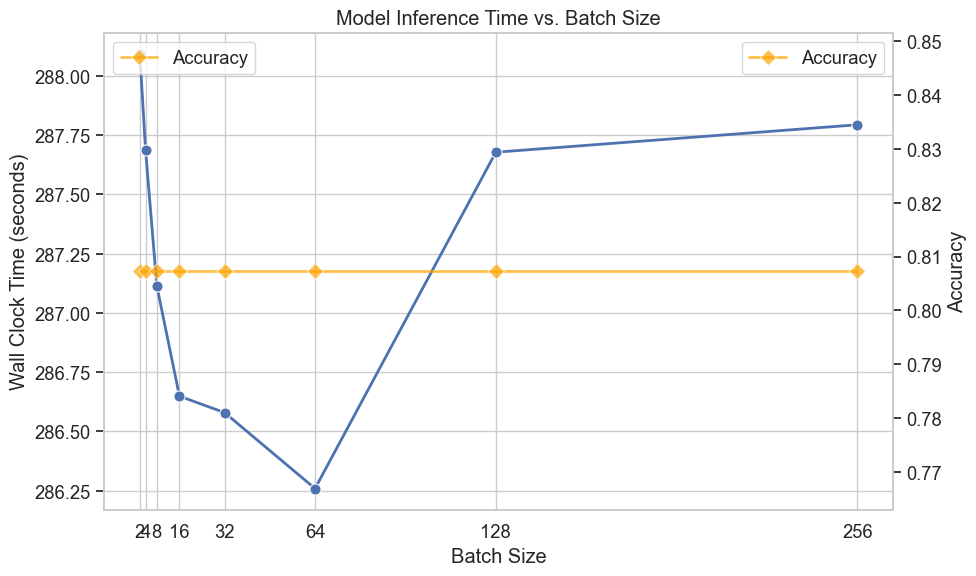

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Create the Plot ---
sns.set_theme(style="whitegrid", font_scale=1.2) # Set a nice, readable theme

plt.figure(figsize=(10, 6)) # Set the figure size

# Use lineplot with markers to show data points clearly
ax = sns.lineplot(
    data=results,
    x='batch_size',          # Batch size on the x-axis
    y='wall_clock_time',     # Wall clock time on the y-axis
    marker='o',              # Add a circle marker for each data point
    markersize=8,            # Make the markers a bit larger
    lw=2                     # Set a nice line width
)

# --- Final Touches ---
# Improve axis labels and title for clarity
ax.set_xlabel('Batch Size')
ax.set_ylabel('Wall Clock Time (seconds)')
ax.set_title('Model Inference Time vs. Batch Size')

# Ensure the x-axis shows all batch sizes as ticks, not just a few
ax.set_xticks(results['batch_size'])

# Optional: Add a secondary y-axis to show how accuracy changes
ax2 = ax.twinx()
ax2 = sns.lineplot(
    data=results, 
    x='batch_size', 
    y='accuracy', 
    ax=ax2, 
    color='orange', 
    marker='D', 
    markersize=8, 
    alpha=0.7,
    lw=2,
    label='Accuracy'
)
ax2.set_ylabel('Accuracy')
ax2.grid(False) # Hide the grid for the secondary axis to avoid clutter

# Get handles and labels for the legend
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='upper left')


plt.tight_layout()
plt.show()


In [17]:
args.num_workers

2

# testing different networks

In [ ]:
args = fovea.Params()
from retinoto_py import all_models

json_filename = args.data_cache / '11_model_comparison.json'

if json_filename.exists():
    results = pd.read_json(json_filename)
else:
    all_results = []
    for model_name in all_models:
        tic = time.time()
        args = fovea.Params(model_name=model_name)
        model = load_model(args)
        param_stats = count_parameters(model)
        total_layers = count_layers(model)
        accuracy = get_validation_accuracy(args, model, val_loader)
        toc = time.time()
        this_result = {'model_name': model_name,
                                'accuracy': accuracy,
                                'wall_clock_time': toc-tic,
                                'total_parameters': param_stats['total_parameters'],
                                'trainable_parameters': param_stats['trainable_parameters'],
                                'total_layers': total_layers}
        all_results.append(this_result)
    results = pd.DataFrame(all_results)
    results.to_json(json_filename, orient='index', indent=2)


Evaluating resnet18:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating resnet50:   0%|          | 0/200 [00:00<?, ?it/s]